In [39]:
# Horray libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.linear_model import LogisticRegression

In [40]:
batch_size = 32
img_height = 180
img_width = 180

In [41]:
from src import make_test_train

In [42]:
test, train = make_test_train()

Found 5072 files belonging to 2 classes.
Found 1765 files belonging to 2 classes.


In [43]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [44]:
preprocess_input = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

In [45]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [46]:
def initialize_model():
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    base_learning_rate = 0.00001

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [47]:
model = initialize_model()

epochs=100
history = model.fit(
    train,
    validation_data=test,
    epochs=epochs
)
test_preds = model.predict(test)
# test_preds.to_csv(ideally with image names, definately with the actual labels)
train_preds = model.predict(train)
# train_preds.to_csv(ideally with image names, definately with the actual labels)

Epoch 1/100
159/159 [==============================] - 330s 2s/step - loss: 0.7911 - accuracy: 0.5091 - val_loss: 0.7682 - val_accuracy: 0.4975
Epoch 2/100
159/159 [==============================] - 346s 2s/step - loss: 0.7490 - accuracy: 0.5479 - val_loss: 0.7259 - val_accuracy: 0.5354
Epoch 3/100
159/159 [==============================] - 367s 2s/step - loss: 0.7236 - accuracy: 0.5655 - val_loss: 0.6912 - val_accuracy: 0.5683
Epoch 4/100
159/159 [==============================] - 376s 2s/step - loss: 0.7013 - accuracy: 0.5769 - val_loss: 0.6627 - val_accuracy: 0.6085
Epoch 5/100
159/159 [==============================] - 382s 2s/step - loss: 0.6582 - accuracy: 0.6201 - val_loss: 0.6420 - val_accuracy: 0.6397
Epoch 6/100
159/159 [==============================] - 386s 2s/step - loss: 0.6459 - accuracy: 0.6250 - val_loss: 0.6174 - val_accuracy: 0.6584
Epoch 7/100
159/159 [==============================] - 388s 2s/step - loss: 0.6307 - accuracy: 0.6418 - val_loss: 0.5996 - val_accuracy:

ValueError: Classification metrics can't handle a mix of binary and continuous targets

model.predict(test.take(6))

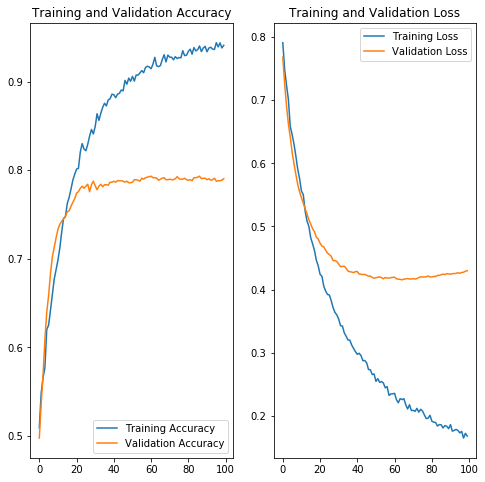

In [49]:
# Results visualisations after ResNet1522
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
neg = 0
pos = 0
test_preds_binary = []
for i in test_preds:
    if i < 0:
        neg += 1
        test_preds_binary.append(0)
    elif i > 0:
        pos += 1
        test_preds_binary.append(1)
print(neg, pos)

822 943


In [70]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

test_labels = np.concatenate([y for x, y in test], axis=0)

cm = confusion_matrix(test_labels, test_preds_binary)
cm

array([[396, 468],
       [426, 475]])

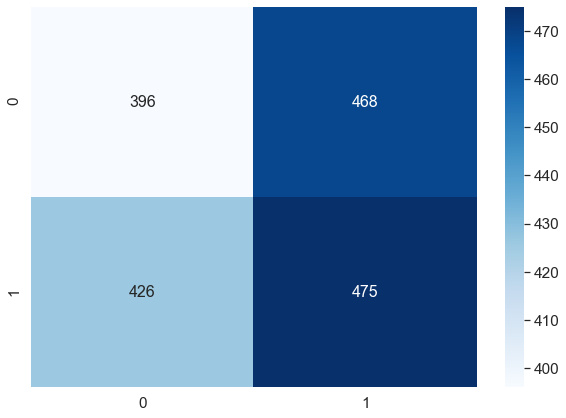

In [87]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')

In [94]:
from sklearn.metrics import recall_score

recall_score(test_labels, test_preds)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [78]:
plot_confusion_matrix(cm, [0, 1], test_labels)

ValueError: plot_confusion_matrix only supports classifiers